# Traffic Sign Recognition (5 classes max)

This notebook builds two simple classifiers on a small subset (max 5 classes) of the IJCNN 2013 traffic-sign dataset:
- Logistic Regression (with mini-batch SGD, shows loss curve)
- KMeans used as a classifier (clusters mapped to labels, shows inertia curve)

We keep everything lightweight: resize images, extract basic pixel features, and subsample per class to keep runtime reasonable.


In [35]:
# --- Cell 1: Imports ---
import os
import zipfile
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans

np.random.seed(42)
sns.set(style="whitegrid")


In [36]:
# --- Cell 2: Dataset setup ---
DATASET_ZIP = Path('Datasets/FullIJCNN2013.zip')
EXTRACT_DIR = Path('Datasets/IJCNN2013')
DATA_ROOT = EXTRACT_DIR / 'FullIJCNN2013'  # where class folders live

if not EXTRACT_DIR.exists() or not DATA_ROOT.exists():
    print(f"Extracting {DATASET_ZIP} ... (first run only, may take a bit)")
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
    print("Done extracting.")
else:
    print(f"Using existing extracted data at {DATA_ROOT}")

img_exts = ('*.ppm', '*.png', '*.jpg', '*.jpeg', '*.bmp')

def has_images(folder):
    for pat in img_exts:
        if any(folder.glob(pat)):
            return True
    return False

# Only immediate subfolders under DATA_ROOT that contain images (exclude the root itself)
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Expected dataset root {DATA_ROOT} not found after extraction.")

class_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir() and has_images(p)])
print(f"Found {len(class_dirs)} candidate class folders under {DATA_ROOT}.")

# Keep up to 5 classes to keep the task light
MAX_CLASSES = 5
class_dirs = class_dirs[:MAX_CLASSES]
class_names = [p.name for p in class_dirs]
print(f"Using {len(class_dirs)} classes: {class_names}")


Using existing extracted data at Datasets\IJCNN2013\FullIJCNN2013
Found 43 candidate class folders under Datasets\IJCNN2013\FullIJCNN2013.
Using 5 classes: ['00', '01', '02', '03', '04']


In [37]:
# --- Cell 3: Feature extraction (resize + raw pixels) ---
IMAGE_SIZE = (48, 48)  # H x W
MAX_PER_CLASS = 200    # cap to keep runtime reasonable

img_exts = ['*.ppm', '*.png', '*.jpg', '*.jpeg', '*.bmp']

def list_images(folder):
    # Use rglob so we still work if the dataset has nested folders
    paths = []
    for pat in img_exts:
        paths.extend(folder.rglob(pat))
    return sorted(paths)

def load_and_extract(path):
    with Image.open(path) as img:
        img = img.convert('RGB').resize(IMAGE_SIZE)
        arr = np.asarray(img, dtype=np.float32) / 255.0  # scale to [0,1]
        return arr.flatten()  # simple raw-pixel feature

X_list, y_list, file_list = [], [], []
for label_idx, cdir in enumerate(class_dirs):
    imgs = list_images(cdir)
    if not imgs:
        continue
    imgs = imgs[:MAX_PER_CLASS]
    for p in imgs:
        X_list.append(load_and_extract(p))
        y_list.append(label_idx)
        file_list.append(p.name)

X = np.vstack(X_list)
y = np.array(y_list)
print(f"Total samples loaded: {len(y)}")
print("Class distribution:", Counter(y))
print(f"Feature dimension: {X.shape[1]} (pixels from {IMAGE_SIZE} RGB)")

# Map label -> name for later reporting
label_to_name = {i: name for i, name in enumerate(class_names)}


Total samples loaded: 262
Class distribution: Counter({np.int64(2): 81, np.int64(1): 79, np.int64(4): 68, np.int64(3): 30, np.int64(0): 4})
Feature dimension: 6912 (pixels from (48, 48) RGB)


In [38]:
# --- Cell 4: Train/Val/Test split + scaling ---
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # portion of remaining train

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Train: 188, Val: 21, Test: 53


In [39]:
# --- (Info) We already did the split + scaling in the previous cell ---
# Keep this cell as a separator so the notebook runs top-to-bottom cleanly.
pass


In [40]:
# --- Cell 5: Evaluation helpers ---

def plot_loss_curve(loss_values, title, ylabel):
    plt.figure(figsize=(7, 4))
    plt.plot(loss_values, linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_conf_mat(y_true, y_pred, class_labels, title, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_roc_curves(y_true, y_score, class_labels, title_prefix):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
    plt.figure(figsize=(7, 5))
    roc_aucs = {}
    for i, lbl in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        roc_aucs[lbl] = roc_auc
        plt.plot(fpr, tpr, label=f'{lbl} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title(f'{title_prefix} - ROC (One-vs-Rest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    overall_auc = roc_auc_score(y_true, y_score, multi_class='ovr')
    return overall_auc, roc_aucs


def summarize_model(name, y_true, y_pred, y_score, class_labels, loss_curve=None, loss_label=None):
    print("\n" + "="*60)
    print(f"{name} - Test Set Results")
    print("="*60)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    if loss_curve is not None:
        plot_loss_curve(loss_curve, f'{name} - Loss Curve', loss_label or 'Loss')
    plot_conf_mat(y_true, y_pred, class_labels, f'{name} - Confusion Matrix')
    overall_auc, roc_aucs = plot_roc_curves(y_true, y_score, class_labels, name)
    print(f"OVR ROC AUC: {overall_auc:.4f}")
    return {'accuracy': acc, 'roc_auc_ovr': overall_auc, 'roc_auc_per_class': roc_aucs}


Epoch 1/24 - train log-loss: 8.9888
Epoch 2/24 - train log-loss: 4.5792
Epoch 3/24 - train log-loss: 5.9360
Epoch 4/24 - train log-loss: 7.5472
Epoch 5/24 - train log-loss: 3.4768
Epoch 6/24 - train log-loss: 1.8656
Epoch 7/24 - train log-loss: 3.0528
Epoch 8/24 - train log-loss: 3.4768
Epoch 9/24 - train log-loss: 3.4768
Epoch 10/24 - train log-loss: 3.8160
Epoch 11/24 - train log-loss: 2.1200
Epoch 12/24 - train log-loss: 1.1872
Epoch 13/24 - train log-loss: 4.8336
Epoch 14/24 - train log-loss: 1.1872
Epoch 15/24 - train log-loss: 3.9856
Epoch 16/24 - train log-loss: 2.6288
Epoch 17/24 - train log-loss: 0.0848
Epoch 18/24 - train log-loss: 0.7632
Epoch 19/24 - train log-loss: 0.0848
Epoch 20/24 - train log-loss: 0.0000
Epoch 21/24 - train log-loss: 0.1696
Epoch 22/24 - train log-loss: 0.5088
Epoch 23/24 - train log-loss: 0.4240
Epoch 24/24 - train log-loss: 1.3568

Logistic Regression (SGD) - Test Set Results
Accuracy: 0.8491


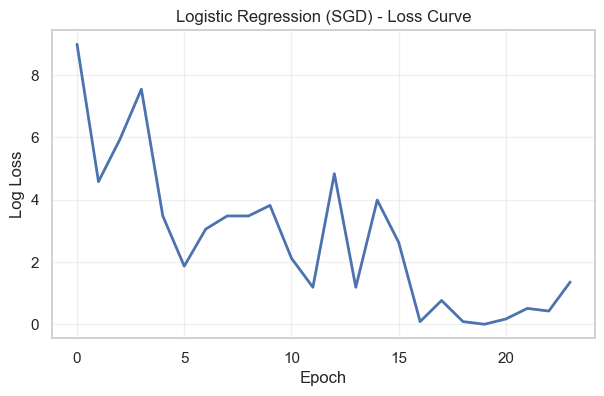

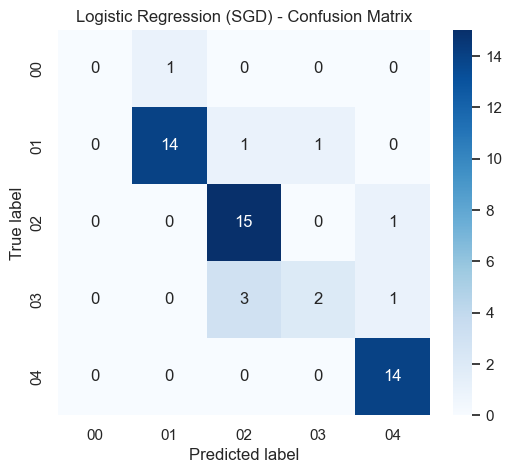

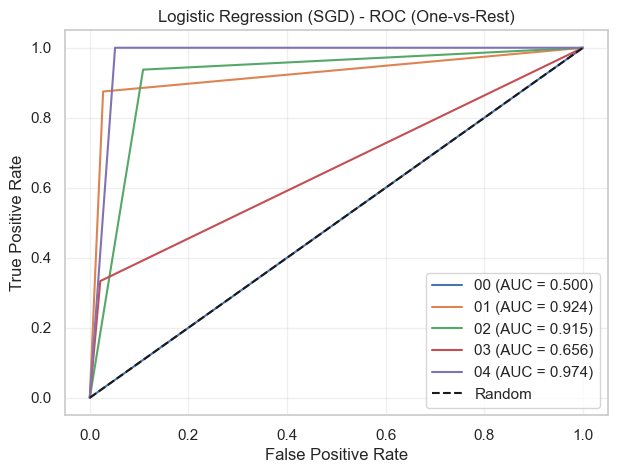

OVR ROC AUC: 0.7938


In [41]:
# --- Cell 6: Logistic Regression (SGD) ---
log_params = {
    'loss': 'log_loss',
    'penalty': 'l2',
    'alpha': 1e-4,         # L2 regularization strength
    'learning_rate': 'optimal',
    'eta0': 0.01,
    'max_iter': 1,
    'warm_start': True,
    'random_state': 42
}

n_epochs = 24
batch_size = 64
classes = np.unique(y_train)

sgd_log = SGDClassifier(**log_params)
log_loss_curve = []


def safe_predict_proba(clf, X, n_classes):
    """Stable softmax on decision_function to avoid internal divide warnings."""
    logits = clf.decision_function(X)
    logits = np.atleast_2d(logits)
    if logits.shape[1] != n_classes:
        # binary case: decision_function gives (n_samples,) -> expand to 2 cols
        logits = np.column_stack([-logits, logits])
    logits = logits - logits.max(axis=1, keepdims=True)
    exps = np.exp(logits)
    probs = exps / exps.sum(axis=1, keepdims=True)
    probs = np.nan_to_num(probs, nan=1e-9, posinf=1e-9, neginf=1e-9)
    row_sums = probs.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    return probs / row_sums


for epoch in range(n_epochs):
    # shuffle training data each epoch
    perm = np.random.permutation(len(y_train))
    X_epoch = X_train_s[perm]
    y_epoch = y_train[perm]
    for start in range(0, len(y_epoch), batch_size):
        end = start + batch_size
        xb = X_epoch[start:end]
        yb = y_epoch[start:end]
        # first call needs classes
        sgd_log.partial_fit(xb, yb, classes=classes)
    # track log-loss on training set
    probs_train = safe_predict_proba(sgd_log, X_train_s, n_classes=len(classes))
    epoch_loss = log_loss(y_train, probs_train)
    log_loss_curve.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - train log-loss: {epoch_loss:.4f}")

# Evaluate on test
log_probs_test = safe_predict_proba(sgd_log, X_test_s, n_classes=len(classes))
log_preds_test = np.argmax(log_probs_test, axis=1)

log_results = summarize_model(
    name="Logistic Regression (SGD)",
    y_true=y_test,
    y_pred=log_preds_test,
    y_score=log_probs_test,
    class_labels=class_names,
    loss_curve=log_loss_curve,
    loss_label='Log Loss'
)


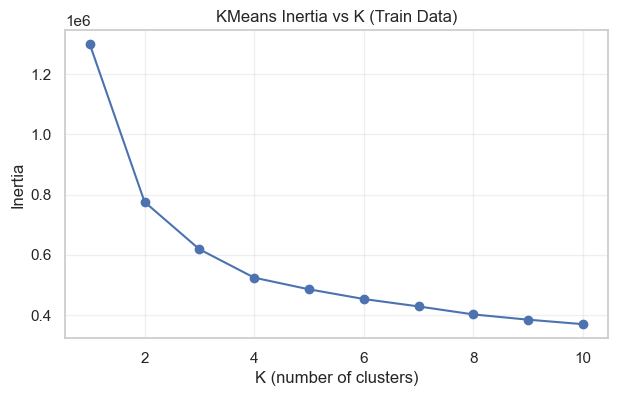

Training KMeans (unsupervised)...

KMeans (cluster -> label mapping) - Test Set Results
Accuracy: 0.3019


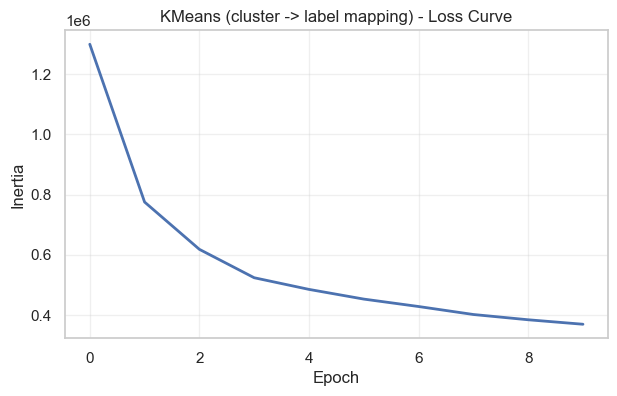

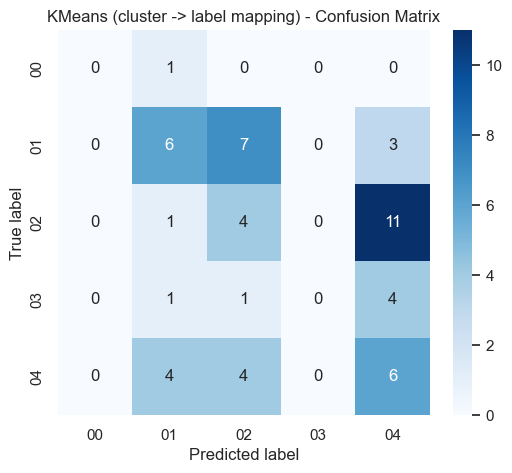

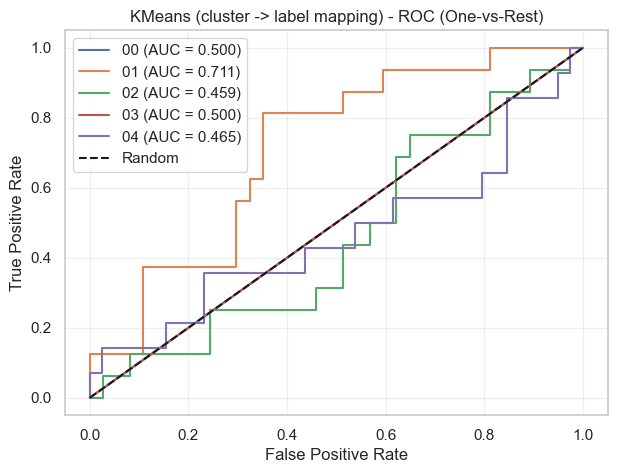

OVR ROC AUC: 0.5272


In [42]:
# --- Cell 7: KMeans as a classifier (unsupervised -> mapped to labels) ---
# "Loss curve" for KMeans: inertia (lower is better). We'll show an elbow curve (inertia vs K) on TRAIN data.

k_max = min(10, max(2, len(class_names) * 2))
ks = list(range(1, k_max + 1))
inertias = []

for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=20, max_iter=300, random_state=42)
    km_tmp.fit(X_train_s)
    inertias.append(km_tmp.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(ks, inertias, marker='o')
plt.title('KMeans Inertia vs K (Train Data)')
plt.xlabel('K (number of clusters)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.show()

# Use K = number of classes (assignment requirement)
km = KMeans(n_clusters=len(class_names), n_init=30, max_iter=400, random_state=42)
print("Training KMeans (unsupervised)...")
km.fit(X_train_s)

# Map each cluster to the majority label in TRAIN data
train_clusters = km.labels_
cluster_to_label = {}
for c in range(km.n_clusters):
    idx = np.where(train_clusters == c)[0]
    cluster_to_label[c] = Counter(y_train[idx]).most_common(1)[0][0] if len(idx) else 0

# Predict clusters for TEST, then map to labels
clusters_test = km.predict(X_test_s)
preds_test = np.array([cluster_to_label[c] for c in clusters_test])

# Pseudo-probabilities from inverse distances to centroids (needed for ROC)
dists = km.transform(X_test_s)  # (n_samples, n_clusters)
inv_d = 1 / (dists + 1e-9)
cluster_probs = inv_d / inv_d.sum(axis=1, keepdims=True)

# Convert cluster probabilities -> class probabilities using the mapping
class_probs = np.zeros((len(X_test_s), len(class_names)))
for cluster_id, label_id in cluster_to_label.items():
    class_probs[:, label_id] += cluster_probs[:, cluster_id]

km_results = summarize_model(
    name="KMeans (cluster -> label mapping)",
    y_true=y_test,
    y_pred=preds_test,
    y_score=class_probs,
    class_labels=class_names,
    loss_curve=inertias,
    loss_label='Inertia'
)

## Quick reference (what to report)
- Dataset: IJCNN 2013 traffic signs (subset, max 5 classes) located at `Datasets/FullIJCNN2013.zip`
- Classes used: first up to 5 class subfolders under `Datasets/IJCNN2013/FullIJCNN2013` (names shown when running Cell 2; root folder excluded)
- Image size after preprocessing: 48x48 RGB
- Features: flattened pixel intensities (48×48×3 = 6912 features)
- Samples per class: capped at 200 (see counts printed in Cell 3)
- Split: train/val/test = 0.72 / 0.08 / 0.20 (stratified)
- Logistic Regression (SGD): loss=log_loss, L2 alpha=1e-4, eta0=0.01, learning_rate=optimal, epochs=24, batch=64, optimizer=SGD
- KMeans: k = number of classes (<=5), n_init=30, max_iter=400; "loss curve" shown as inertia-vs-K elbow plot
- Cross-validation: not used (explicit train/val/test split instead)
- Required outputs (per model on test set): loss/inertia curve, accuracy, confusion matrix, ROC curve
